Now that we have somewhat of a pipeline for analyzing CNVs in PLINK, let's go back to the XHMM results. Remember that we used the default XHMM parameters, and these were some of our QC results:

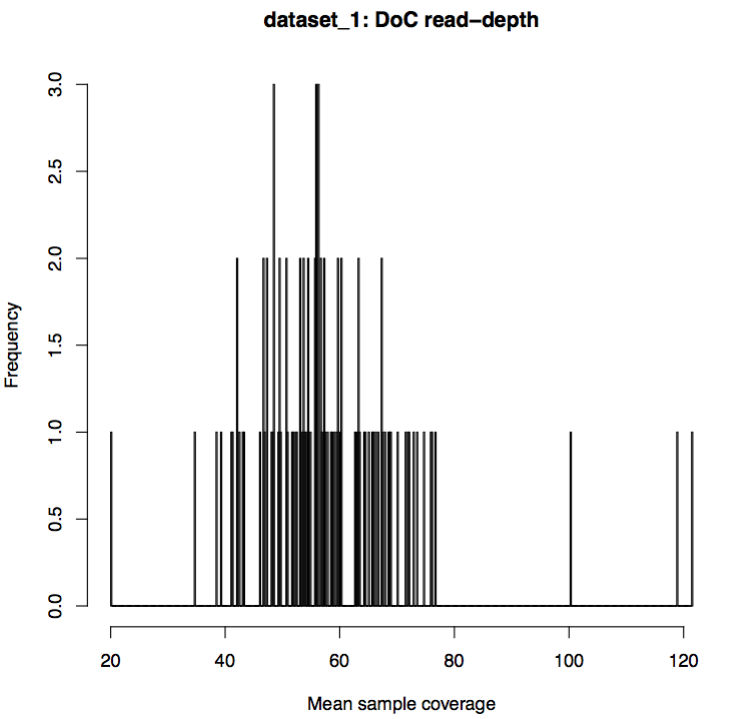

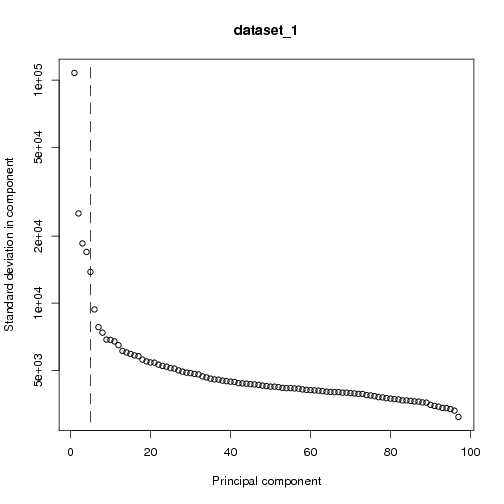

So, I'm going to copy the DATA files resulting from that analysis, and let's see what we can get in PLINK/PSEQ:

In [1]:
module load plinkseq
module load plink/1.07

cd ~/data/cnv/xhmm
cp /data/NCR_SBRB/simplex/xhmm/DATA.vcf .

[-] Unloading GSL 2.2.1 ...
[-] Unloading Graphviz v2.38.0 ...
[-] Unloading gdal 2.0 ...
[-] Unloading proj 4.9.2 ...
[-] Unloading gcc 4.9.1 ...
[-] Unloading openmpi 1.10.0 for GCC 4.9.1
[-] Unloading tcl_tk 8.6.3
[-] Unloading Zlib 1.2.8 ...
[-] Unloading Bzip2 1.0.6 ...
[-] Unloading pcre 8.38 ...
[-] Unloading liblzma 5.2.2 ...
[-] Unloading libjpeg-turbo 1.5.1 ...
[-] Unloading tiff 4.0.7 ...
[-] Unloading curl 7.46.0 ...
[-] Unloading boost libraries v1.65 ...
[-] Unloading R 3.4.0 on cn3744
[+] Loading GSL 2.2.1 ...
[+] Loading Graphviz v2.38.0 ...
[+] Loading gdal 2.0 ...
[+] Loading proj 4.9.2 ...
[+] Loading gcc 4.9.1 ...
[+] Loading openmpi 1.10.0 for GCC 4.9.1
[+] Loading tcl_tk 8.6.3
[+] Loading Zlib 1.2.8 ...
[+] Loading Bzip2 1.0.6 ...
[+] Loading pcre 8.38 ...
[+] Loading liblzma 5.2.2 ...
[-] Unloading Zlib 1.2.8 ...
[+] Loading Zlib 1.2.8 ...
[-] Unloading liblzma 5.2.2 ...
[+] Loading liblzma 5.2.2 ...
[+] Loading libjpeg-turbo 1.5.1 ...
[+] Loading tiff 4.0.7 ...


Now, remember that CCGO_800976 was removed during sample filtering step in XHMM, so we need to remove family members of 10369 as it's a father.

In [2]:
pseq DATA new-project
# adding a first column with subject ID for PSEQ
cut -f 2 ../simplex.ped > junk.txt
paste junk.txt ../simplex.ped > simplex.ped.info
pseq DATA load-pedigree --file simplex.ped.info
pseq DATA load-vcf --vcf DATA.vcf
pseq DATA cnv-denovo --noweb --minSQ 60 --minNQ 60 --out DATA

 failed connectionCreating new project specification file [ DATA.pseq ]
Inserted 99 new individuals, updated 0 existing individuals
loading : /spin1/users/sudregp/cnv/xhmm/DATA.vcf ( 98 individuals )
parsed 8000 rows        
/spin1/users/sudregp/cnv/xhmm/DATA.vcf : inserted 8324 variants
-------------------------------------------------------------------------------
||||||||||||||||||||||||||| PSEQ (v0.10; 14-Jul-14) |||||||||||||||||||||||||||
-------------------------------------------------------------------------------

Copying this log to file [ DATA.log ]
Analysis started Thu Dec 21 13:04:32 2017

-------------------------------------------------------------------------------

Project : DATA
Command : cnv-denovo
Options : --noweb
          --minSQ 60
          --minNQ 60
          --out DATA

-------------------------------------------------------------------------------

Writing to file [ DATA.denovo.cnv ]  : per-site output from cnv-denovo
Writing to file [ DATA.denovo.cnv.indi

Now, just like what we did for PennCNV, let's create PLINK files for denovo, inherited, and everything. We do have this knob of quality to play with beforehand, so let's keep that in mind.

If I'm just interested in numbers, I could just grab the information from the DATA.denovo.cnv.indiv file, which looks like this:

In [3]:
head DATA.denovo.cnv.indiv

#SUMMARY	CHILD	CHILD_CNV	IN_PATERNAL	IN_MATERNAL	IN_PATERNAL_AND_MATERNAL	MISSING_PATERNAL	MISSING_MATERNAL	DE_NOVO	PATERNAL_TRANSMITTED	PATERNAL_NON_TRANSMITTED	PATERNAL_UNKNOWN	MATERNAL_TRANSMITTED	MATERNAL_NON_TRANSMITTED	MATERNAL_UNKNOWN
SUMMARY	CLIA_400121	111	34	25	5	44	44	10	18	24	18	9	24	16
SUMMARY	CLIA_400122	137	48	65	25	45	40	13	11	11	19	22	27	25
SUMMARY	CLIA_400123	103	10	20	1	36	39	26	2	9	7	14	42	24
SUMMARY	CLIA_400125	97	30	37	8	31	27	7	13	29	23	19	18	15
SUMMARY	CLIA_400126	116	30	33	6	32	42	19	12	40	24	19	23	21
SUMMARY	CLIA_400127	109	27	28	5	37	43	13	15	31	22	11	21	16
SUMMARY	CLIA_400128	124	44	27	6	45	42	13	22	23	19	13	13	16
SUMMARY	CLIA_400129	115	36	45	9	41	36	8	16	19	21	21	22	23
SUMMARY	CLIA_400130	109	27	28	4	52	42	9	13	13	13	9	19	16


But I'll likely want to do some further filtering in PLINK, so I'l need the non .indiv file.

In [4]:
head DATA.denovo.cnv | cut -f 1 | sort | uniq

#CLASS
DENOVO
MATERNAL_NON_TRANSMITTED
MATERNAL_TRANSMITTED
MATERNAL_UNKNOWN
PATERNAL_NON_TRANSMITTED
PATERNAL_TRANSMITTED
PATERNAL_UNKNOWN


Let's format the file into something PLINK can understand. XHMM has a script to convert from xcnv to cnv, so we just need to filter all DENOVO calls from PSEQ in the main xcnv file:

In [17]:
# create a list of kids first
while read line; do
    read -r -a array <<< "$line";
    id=${array[1]}
    fa=${array[2]}
    mo=${array[3]}

    # figure out relationship
    if [ $fa != 0 ] && [ $mo != 0 ]; then
        child=${id};
        echo $child >> ../kid_samples.txt;
    fi;
done < ../simplex.ped

In [41]:
grep DENOVO DATA.denovo.cnv > pseq_DENOVO.txt
# borrow the header row
head -1 DATA.xcnv > denovo.xcnv;

while read sample; do
    grep $sample DATA.xcnv > sample.xcnv;
    for cnv in `grep $sample pseq_DENOVO.txt | cut -f 3 -`; do
        # replacing .. by -
        cnv=`echo $cnv | sed -e 's/\.\./\-/'`;
        grep $cnv sample.xcnv >> denovo.xcnv; 
    done;
done < ../kid_samples.txt;
/usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv denovo.xcnv > tmp.cnv
# switch around FAMID and IID columns, and remove header
awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > denovo.cnv
rm sample.xcnv pseq_DENOVO.txt tmp.cnv denovo.xcnv

In [40]:
grep MATERNAL_TRANSMITTED DATA.denovo.cnv > pseq_TRANSMITTED.txt
grep PATERNAL_TRANSMITTED DATA.denovo.cnv >> pseq_TRANSMITTED.txt
# borrow the header row
head -1 DATA.xcnv > inherited.xcnv;

while read sample; do
    grep $sample DATA.xcnv > sample.xcnv;
    for cnv in `grep $sample pseq_TRANSMITTED.txt | cut -f 3 -`; do
        # replacing .. by -
        cnv=`echo $cnv | sed -e 's/\.\./\-/'`;
        grep $cnv sample.xcnv >> inherited.xcnv; 
    done;
done < ../kid_samples.txt;
/usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv inherited.xcnv > tmp.cnv
# switch around FAMID and IID columns, and remove header
awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > inherited.cnv
rm sample.xcnv pseq_TRANSMITTED.txt tmp.cnv inherited.xcnv

In [42]:
# borrow the header row
head -1 DATA.xcnv > all.xcnv;

# effectively just filtering DATA.xcnv to keep only kids
while read sample; do
    grep $sample DATA.xcnv >> all.xcnv;
done < ../kid_samples.txt;
/usr/local/apps/XHMM/2016-01-04/sources/scripts/xcnv_to_cnv all.xcnv > tmp.cnv
# switch around FAMID and IID columns, and remove header
awk '{OFS="\t"; if ( $3 != "CHR" ) {print $2, $1, $3, $4, $5, $6, $7, $8 }}' tmp.cnv > all.cnv
rm tmp.cnv all.xcnv

The issue here is that PSEQ doesn't carry forward the FAMID, so PLINK doesn't know how to add the information back to the sample IDs, which all have FAMIDs in the .ped. So, we need to create a .ped without FAMIDs, whic is fine since at this point all the family information has already been used, and PLINK doesn't need it anymore.

In [35]:
rm ones.txt;
nsamples=`cat ../simplex.ped | wc -l`
for i in `seq 1 $nsamples`; do echo 1 >> ones.txt; done;
cut -f 2,3,4,5,6 ../simplex.ped > junk;
paste ones.txt junk > ../simplex_nofamid.ped;

In [2]:
for cnvtype in all denovo inherited; do
    cnvname=${cnvtype}.cnv
    plink --cnv-list $cnvname --cnv-make-map --noweb --out ${cnvtype};
    # whole burden
    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
        --noweb --1 --cnv-check-no-overlap --out ${cnvtype}_burden;
    # gene sets
    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
        --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
        --cnv-subset genes.txt --out ${cnvtype}_genes;
    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
        --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
        --cnv-subset hg19_allenBrainGene_trimmed.txt \
        --out ${cnvtype}_brainGenes;
    # subtypes only
    for sub in del dup; do
        plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
        --noweb --1 --cnv-${sub} --out ${cnvtype}_${sub}Burden;
        # gene sets
        plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
            --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
            --cnv-subset genes.txt --cnv-${sub} \
            --out ${cnvtype}_${sub}Genes;
        plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
            --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
            --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
            --out ${cnvtype}_${sub}BrainGenes;
    done;
done


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all.log ]
Analysis started: Thu Dec 21 15:23:26 2017

Options in effect:
	--cnv-list all.cnv
	--cnv-make-map
	--noweb
	--out all


Reading segment list (CNVs) from [ all.cnv ]
Writing new MAP file to [ all.cnv.map ]
Wrote 10382 unique positions to file

Analysis finished: Thu Dec 21 15:23:27 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|--------------------

|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_delGenes.log ]
Analysis started: Thu Dec 21 15:23:35 2017

Options in effect:
	--map all.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-del
	--out all_delGenes

Reading marker information from [ all.cnv.map ]
10382 (of 10382) markers to be included from [ all.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 


	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-dup
	--out all_dupBrainGenes

Reading marker information from [ all.cnv.map ]
10382 (of 10382) markers to be included from [ all.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_dupBrainGenes.notfound ] 

Reading segment list (CNVs) from [ all.cnv ]
Writing back list to intersected regions to [ all_dupBrainGenes.reg ]
7223 mapped to a person, of which 3651 passed filters

|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_delBurden.log ]
Analysis started: Thu Dec 21 15:23:45 2017

Options in effect:
	--map denovo.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo.cnv
	--noweb
	--1
	--cnv-del
	--out denovo_delBurden

Reading marker information from [ denovo.cnv.map ]
1757 (of 1757) markers to be included from [ denovo.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ denovo.cnv ]
665 mapped to a

21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ denovo.cnv ]
Writing back list to intersected regions to [ denovo_dupGenes.reg ]
665 mapped to a person, of which 258 passed filters
227 intersected with one or more specified region
227 of 665 mapped as valid segments
 CopyN Case/Control
     3    104 / 123

Writing per-individual summary to [ denovo_dupGenes.cnv.indiv ]
Writing positional summary to [ denovo_dupGenes.cnv.summary ]

Analysis finished: Thu Dec 21 15:23:47 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|---------------------

	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--out inherited_brainGenes

Reading marker information from [ inherited.cnv.map ]
807 (of 807) markers to be included from [ inherited.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_brainGenes.notfound ] 

Reading segment list (CNVs) from [ inherited.cnv ]
Writing back list to intersected regions to [ inherited_brainGenes.reg ]
401 mapped to a person, of which 401 pass

21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited.cnv ]
401 mapped to a person, of which 187 passed filters
187 of 401 mapped as valid segments
 CopyN Case/Control
     3      88 / 99

Writing per-individual summary to [ inherited_dupBurden.cnv.indiv ]
Writing positional summary to [ inherited_dupBurden.cnv.summary ]

Analysis finished: Thu Dec 21 15:23:49 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [

Now let's do some plotting in Python.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
# figure out who is who in each trio
import glob
ped_file = '/data/sudregp/cnv/simplex.ped'
wes_prefix = ['CLIA', 'CCGO', 'WPS']
trios = []
affected = []
controls = []
samples = []
famids = []
fid = open(ped_file, 'r')
for line in fid:
    famid, sid, fa, mo, sex, aff = line.rstrip().split('\t')
    if fa[:4] in wes_prefix and mo[:4] in wes_prefix and sid[:4] in wes_prefix:
        fam = {}
        fam['child'] = sid
        if aff == '1':
            affected.append(sid)
        else:
            controls.append(sid)
        fam['father'] = fa
        fam['mother'] = mo
        fam['famid'] = famid
        trios.append(fam)
        samples += [sid, fa, mo]
        famids.append(famid)
fid.close()
samples = set(samples)
famids = set(famids)

fid = open('/data/sudregp/cnv/kid_samples.txt', 'r')
good_kids = [line.rstrip() for line in fid]
fid.close()

In [3]:
def plot_plink_cnvs(fname, t_str, verbose=False):
    
    import plotly.graph_objs as go
    from plotly import tools

    df = pd.read_table(fname, delimiter='\s+', index_col=1)
    df.head()

    x_red, x_green, red, green, xticks = [], [], [], [], []
    red_text, green_text = [], []

    # loop through families
    f = 0
    for fam in famids:
        fam_kids = [t['child'] for t in trios if t['famid'] == fam]
        found = False
        for kid in fam_kids:
            if kid in good_kids:
                found = True
                idx = [i for i in range(df.shape[0]) if df.index[i].find(kid) >= 0][0]
                if kid in affected:
                    red.append(int(df.iloc[idx]['NSEG']))
                    x_red.append(f)
                    red_text.append(kid)
                else:
                    green.append(int(df.iloc[idx]['NSEG']))
                    x_green.append(f)
                    green_text.append(kid)
        # only increase counter if we added a kid
        if found:
            xticks.append(fam)
            f += 1

    fig = go.Figure()
                
    trace0 = go.Scatter(
        x = x_red,
        y = red,
        mode = 'markers',
        name = 'affected',
        marker = dict(size = 10, color = 'red'),
        text = red_text,
        hoverinfo='text+y',
        showlegend = True
    )
    trace1 = go.Scatter(
        x = x_green,
        y = green,
        mode = 'markers',
        name = 'unaffected',
        marker = dict(size = 10, color = 'green'),
        hovertext = green_text,
        hoverinfo='text+y',
        showlegend = True
    )
    fig['data'] = [trace0, trace1]
    fig['layout'].update(height=400, width=800, title=t_str,
                             xaxis1=dict(tickvals=range(len(xticks)),
                                        ticktext=xticks,
                                        zeroline = False),
                             hovermode='closest')
    iplot(fig)
    
    # print family order
    if verbose:
        score = []
        for x in range(max(x_green + x_red)):
            idx = [i for i, val in enumerate(x_red) if val == x]
            if len(idx) == 0:
                aff = 0
            else:
                aff = red[idx[0]]
            idx = [i for i, val in enumerate(x_green) if val == x]
            if len(idx) == 0:
                unaff = 0
            else:
                unaff = max([green[i] for i in idx])
            score.append(aff - unaff)
        order = np.argsort(score)[::-1]
        fam_names = fig.layout.xaxis1['ticktext']
        disrupted = [fam_names[v] for v in order if score[v] > 0]
        print 'Best disrupted:', ', '.join(disrupted)
        protected = [fam_names[v] for v in order[::-1] if score[v] < 0]
        print 'Best protected:', ', '.join(protected)

In [4]:
import glob

data_dir = '/home/sudregp/data/cnv/xhmm/'
files = glob.glob(data_dir + '/denovo*cnv.indiv')
for f in files:
    t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
    plot_plink_cnvs(f, t_str, verbose=True)

Best disrupted: 10406, 10042, 10090, 10173, 10033, 10178, 10164, 1895, 1893, 10128, 10197
Best protected: 10094, 10131, 10448, 10041, 855, 1892, 10182, 10215


Best disrupted: 10406, 10042, 10153, 10173, 10033, 10197, 1893, 10164, 10448, 10178
Best protected: 10094, 855, 1895, 10041, 10128, 10090, 10215, 10131


Best disrupted: 10090, 1895, 10042, 10173, 10128, 10033, 10164, 10178, 855, 1893, 10197
Best protected: 10131, 10448, 10406, 10153, 10041, 10215, 10182, 1892, 10094


Best disrupted: 10406, 10042, 10173, 10090, 10033, 10178, 10197, 10164, 10128, 1893, 1895
Best protected: 10131, 10094, 10448, 10041, 1892, 10182, 10215


Best disrupted: 10406, 10197
Best protected: 10041, 10215, 1895


Best disrupted: 10406, 10042, 10153, 10173, 10197, 10033, 10164, 10131, 10178
Best protected: 10094, 855, 1895, 10041, 10090, 10215, 10128, 1892, 10182


Best disrupted: 10406
Best protected: 10215, 1895


Best disrupted: 10090, 10042, 10173, 855, 10033, 10128, 1895, 10164, 10178, 10197, 1893
Best protected: 10131, 10448, 10153, 10041, 10406, 1892, 10215


Best disrupted: 10197
Best protected: 10041


It's interesting that the overall results here differ from what we get from PennCNV, in terms of the most affected families. Also, the results where we don't clean up based on gene sets (and even those, to a certain extent), could certainly use some cleaning. Let's start with just the most common CNVs, for now.

In [3]:
cd ~/data/cnv/xhmm
module load plink/1.07

cat ../penncnv/wellknown_region_hg19 > bad_regions.list

for cnvtype in all denovo inherited; do
    cnvname=${cnvtype}.cnv

    # remove bad regions
    plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
        --noweb --1 --cnv-exclude bad_regions.list --cnv-overlap .5 \
        --cnv-write --out ${cnvtype}_clean
    plink --cnv-list ${cnvtype}_clean.cnv --cnv-make-map --noweb --1 \
        --out ${cnvtype}_clean
done


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_clean.log ]
Analysis started: Thu Dec 21 15:31:31 2017

Options in effect:
	--map all.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all.cnv
	--noweb
	--1
	--cnv-exclude bad_regions.list
	--cnv-overlap .5
	--cnv-write
	--out all_clean

Reading marker information from [ all.cnv.map ]
10382 (of 10382) markers to be included from [ all.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information

I'm going to crop based on CNV length just at 500 for now, but I still need to histogram them to see what're the best values.

In [5]:
cd ~/data/cnv/xhmm

for cnvtype in all denovo inherited; do
    for qc in '' '_clean'; do
        cnvname=${cnvtype}${qc}.cnv
        # apply CNV length threshold in clean and nonclean sets
        for kb in 0 500; do
            # whole burden
            plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-check-no-overlap --cnv-kb $kb \
                --out ${cnvtype}${qc}_lenBT${kb}_burden;
            # gene sets
            plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset genes.txt --cnv-kb $kb \
                --out ${cnvtype}${qc}_lenBT${kb}_genes;
            plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-kb $kb \
                --out ${cnvtype}${qc}_lenBT${kb}_brainGenes;
            # subtypes only
            for sub in del dup; do
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                --noweb --1 --cnv-${sub} --cnv-kb $kb \
                --out ${cnvtype}${qc}_lenBT${kb}_${sub}Burden;
                # gene sets
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset genes.txt --cnv-${sub} --cnv-kb $kb\
                    --out ${cnvtype}${qc}_lenBT${kb}_${sub}Genes;
                plink --map ${cnvname}.map --fam ../simplex_nofamid.ped --cnv-list $cnvname \
                    --noweb --1 --cnv-intersect glist-hg19 --cnv-verbose-report-regions \
                    --cnv-subset hg19_allenBrainGene_trimmed.txt --cnv-${sub} \
                    --cnv-kb $kb \
                    --out ${cnvtype}${qc}_lenBT${kb}_${sub}BrainGenes;
            done;
        done;
    done;
done


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_lenBT0_burden.log ]
Analysis started: Thu Dec 21 15:39:41 2017

Options in effect:
	--map all.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--cnv-kb 0
	--out all_lenBT0_burden

Reading marker information from [ all.cnv.map ]
10382 (of 10382) markers to be included from [ all.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../

	--cnv-del
	--cnv-kb 0
	--out all_lenBT0_delGenes

Reading marker information from [ all.cnv.map ]
10382 (of 10382) markers to be included from [ all.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ all.cnv ]
Writing back list to intersected regions to [ all_lenBT0_delGenes.reg ]
7223 mapped to a person, of which 3572 passed filters
3062 intersected with one or more specified region
3062 of 7223 mapped as valid segments
 CopyN Case/Control
     1  1527 / 1

21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_lenBT0_dupBrainGenes.notfound ] 

Reading segment list (CNVs) from [ all.cnv ]
Writing back list to intersected regions to [ all_lenBT0_dupBrainGenes.reg ]
7223 mapped to a person, of which 3651 passed filters
33 intersected with one or more specified region
33 of 7223 mapped as valid segments
 CopyN Case/Control
     3      14 / 19

Writing per-individual summary to [ all_lenBT0_dupBrainGenes.cnv.indiv ]
Writing positional summary to [ all_lenBT0_dupBrainGenes.cnv.summary ]

Analysis finished: Thu Dec 21 15:39:58 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|---------------


Analysis finished: Thu Dec 21 15:39:59 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_lenBT500_delGenes.log ]
Analysis started: Thu Dec 21 15:39:59 2017

Options in effect:
	--map all.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-del
	--cnv-kb 500
	--out all_lenBT500_delGenes

Reading marker information from [ all.cnv.map ]
10382 (of 10382) markers to be include

@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_lenBT500_dupBrainGenes.log ]
Analysis started: Thu Dec 21 15:40:01 2017

Options in effect:
	--map all.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-dup
	--cnv-kb 500
	--out all_lenBT500_dupBrainGenes

Reading marker information from [ all.cnv.map ]
10382 (of 10382) markers to be included from [ all.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGen

Analysis started: Thu Dec 21 15:40:02 2017

Options in effect:
	--map all_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_clean.cnv
	--noweb
	--1
	--cnv-del
	--cnv-kb 0
	--out all_clean_lenBT0_delBurden

Reading marker information from [ all_clean.cnv.map ]
463 (of 463) markers to be included from [ all_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ all_clean.cnv ]
191 mapped to a person, of which 109 passed filters
109 of 191 mapped as valid segments
 CopyN Case/Control
     1      87 / 22

Writing per-individual summary to [ all_clean_lenBT0_delBurden.cnv.indiv ]
Writing positional summary to [ all_clean_lenBT0_d

Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ all_clean.cnv ]
Writing back list to intersected regions to [ all_clean_lenBT0_dupGenes.reg ]
191 mapped to a person, of which 82 passed filters
78 intersected with one or more specified region
78 of 191 mapped as valid segments
 CopyN Case/Control
     3      27 / 51

Writing per-individual summary to [ all_clean_lenBT0_dupGenes.cnv.indiv ]
Writing positional summary to [ all_clean_lenBT0_dupGenes.cnv.summary ]

Analysis finished: Thu Dec 21 15:40:03 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|-------------------------------------------------------

Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ all_clean_lenBT500_brainGenes.notfound ] 

Reading segment list (CNVs) from [ all_clean.cnv ]
Writing back list to intersected regions to [ all_clean_lenBT500_brainGenes.reg ]
191 mapped to a person, of which 11 passed filters
2 intersected with one or more specified region
2 of 191 mapped as valid segments
 CopyN Case/Control
     1        2 / 0

Writing per-individual summary to [ all_clean_lenBT500_brainGenes.cnv.indiv ]
Writing positional summary to [ all_clean_lenBT500_brainGenes.cnv.summary ]

Analysis finished: Thu Dec 21 15:40:03 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|------------------------------

Writing positional summary to [ all_clean_lenBT500_dupBurden.cnv.summary ]

Analysis finished: Thu Dec 21 15:40:04 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ all_clean_lenBT500_dupGenes.log ]
Analysis started: Thu Dec 21 15:40:04 2017

Options in effect:
	--map all_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list all_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-dup
	--cnv-kb 500
	--out all_clean_lenBT5

|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_lenBT0_brainGenes.log ]
Analysis started: Thu Dec 21 15:40:05 2017

Options in effect:
	--map denovo.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-kb 0
	--out denovo_lenBT0_brainGenes

Reading marker information from [ denovo.cnv.map ]
1757 (of 1757) markers to be included from [ denovo.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 i

@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_lenBT0_dupBurden.log ]
Analysis started: Thu Dec 21 15:40:06 2017

Options in effect:
	--map denovo.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo.cnv
	--noweb
	--1
	--cnv-dup
	--cnv-kb 0
	--out denovo_lenBT0_dupBurden

Reading marker information from [ denovo.cnv.map ]
1757 (of 1757) markers to be included from [ denovo.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ denovo.cnv ]
665 mapped to a person, of which 258 passed filters
258 of 665 mapped as valid segments
 CopyN Case/Control
   

99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ denovo.cnv ]
Writing back list to intersected regions to [ denovo_lenBT500_genes.reg ]
665 mapped to a person, of which 1 passed filters
1 intersected with one or more specified region
1 of 665 mapped as valid segments
 CopyN Case/Control
     1        1 / 0

Writing per-individual summary to [ denovo_lenBT500_genes.cnv.indiv ]
Writing positional summary to [ denovo_lenBT500_genes.cnv.summary ]

Analysis finished: Thu Dec 21 15:40:07 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|-------------------------------

Could not find 29 ranges
Writing this list to [ denovo_lenBT500_delBrainGenes.notfound ] 

Reading segment list (CNVs) from [ denovo.cnv ]
Writing back list to intersected regions to [ denovo_lenBT500_delBrainGenes.reg ]
665 mapped to a person, of which 1 passed filters
0 intersected with one or more specified region
0 of 665 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ denovo_lenBT500_delBrainGenes.cnv.indiv ]
Writing positional summary to [ denovo_lenBT500_delBrainGenes.cnv.summary ]

Analysis finished: Thu Dec 21 15:40:08 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        

|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_clean_lenBT0_genes.log ]
Analysis started: Thu Dec 21 15:40:08 2017

Options in effect:
	--map denovo_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-kb 0
	--out denovo_clean_lenBT0_genes

Reading marker information from [ denovo_clean.cnv.map ]
147 (of 147) markers to be included from [ denovo_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.p

|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_clean_lenBT0_delBrainGenes.log ]
Analysis started: Thu Dec 21 15:40:09 2017

Options in effect:
	--map denovo_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_clean.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-del
	--cnv-kb 0
	--out denovo_clean_lenBT0_delBrainGenes

Reading marker information from [ denovo_clean.cnv.map ]
147 (of 147) markers to be included from [ denovo_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing


@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ denovo_clean_lenBT500_burden.log ]
Analysis started: Thu Dec 21 15:40:10 2017

Options in effect:
	--map denovo_clean.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list denovo_clean.cnv
	--noweb
	--1
	--cnv-check-no-overlap
	--cnv-kb 500
	--out denovo_clean_lenBT500_burden

Reading marker information from [ denovo_clean.cnv.map ]
147 (of 147) markers to be included from [ denovo_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ denovo_clean.cnv ]
No overlapping samples found
51 mapped to a person, of whi

Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ denovo_clean.cnv ]
Writing back list to intersected regions to [ denovo_clean_lenBT500_delGenes.reg ]
51 mapped to a person, of which 1 passed filters
1 intersected with one or more specified region
1 of 51 mapped as valid segments
 CopyN Case/Control
     1        1 / 0

Writing per-individual summary to [ denovo_clean_lenBT500_delGenes.cnv.indiv ]
Writing positional summary to [ denovo_clean_lenBT500_delGenes.cnv.su

99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ denovo_clean_lenBT500_dupBrainGenes.notfound ] 

Reading segment list (CNVs) from [ denovo_clean.cnv ]
Writing back list to intersected regions to [ denovo_clean_lenBT500_dupBrainGenes.reg ]
51 mapped to a person, of which 0 passed filters
0 intersected with one or more specified region
0 of 51 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ denovo_clean_lenBT500_dupBrainGenes.cnv.indiv ]
Writing positional summary to [ denovo_clean_lenBT500_dupBrainGenes.cnv.summary ]

Analysis finished: Thu Dec 21 15:40:11 2017


@-------------

401 mapped to a person, of which 214 passed filters
214 of 401 mapped as valid segments
 CopyN Case/Control
     1     95 / 119

Writing per-individual summary to [ inherited_lenBT0_delBurden.cnv.indiv ]
Writing positional summary to [ inherited_lenBT0_delBurden.cnv.summary ]

Analysis finished: Thu Dec 21 15:40:12 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_lenBT0_delGenes.log ]
Analysis started: Thu Dec 21 15:40:12 2017

Options in effect:
	--map inherited.cnv.map



Analysis finished: Thu Dec 21 15:40:13 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_lenBT0_dupBrainGenes.log ]
Analysis started: Thu Dec 21 15:40:13 2017

Options in effect:
	--map inherited.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list inherited.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-dup
	--cnv-kb 0
	--out inherited_lenBT0_dupBrainGenes

Reading marker information from [ in

|        PLINK!       |     v1.07      |   10/Aug/2009     |
|----------------------------------------------------------|
|  (C) 2009 Shaun Purcell, GNU General Public License, v2  |
|----------------------------------------------------------|
|  For documentation, citation & bug-report instructions:  |
|        http://pngu.mgh.harvard.edu/purcell/plink/        |
@----------------------------------------------------------@

Skipping web check... [ --noweb ] 
Writing this text to log file [ inherited_lenBT500_delBurden.log ]
Analysis started: Thu Dec 21 15:40:13 2017

Options in effect:
	--map inherited.cnv.map
	--fam ../simplex_nofamid.ped
	--cnv-list inherited.cnv
	--noweb
	--1
	--cnv-del
	--cnv-kb 500
	--out inherited_lenBT500_delBurden

Reading marker information from [ inherited.cnv.map ]
807 (of 807) markers to be included from [ inherited.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 indiv

	--cnv-list inherited.cnv
	--noweb
	--1
	--cnv-intersect glist-hg19
	--cnv-verbose-report-regions
	--cnv-subset genes.txt
	--cnv-dup
	--cnv-kb 500
	--out inherited_lenBT500_dupGenes

Reading marker information from [ inherited.cnv.map ]
807 (of 807) markers to be included from [ inherited.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ inherited.cnv ]
Writing back list to intersected regions to [ inherited_lenBT500_dupGenes.reg ]
401 mapped to a person, o

	--cnv-subset hg19_allenBrainGene_trimmed.txt
	--cnv-kb 0
	--out inherited_clean_lenBT0_brainGenes

Reading marker information from [ inherited_clean.cnv.map ]
12 (of 12) markers to be included from [ inherited_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_clean_lenBT0_brainGenes.notfound ] 

Reading segment list (CNVs) from [ inherited_clean.cnv ]
Writing back list to intersected regions to [ inherited_clea

	--cnv-kb 0
	--out inherited_clean_lenBT0_dupBurden

Reading marker information from [ inherited_clean.cnv.map ]
12 (of 12) markers to be included from [ inherited_clean.cnv.map ]
Reading individual information from [ ../simplex_nofamid.ped ]
Reading pedigree information from [ ../simplex_nofamid.ped ] 
99 individuals read from [ ../simplex_nofamid.ped ] 
99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex

Reading segment list (CNVs) from [ inherited_clean.cnv ]
4 mapped to a person, of which 1 passed filters
1 of 4 mapped as valid segments
 CopyN Case/Control
     3        1 / 0

Writing per-individual summary to [ inherited_clean_lenBT0_dupBurden.cnv.indiv ]
Writing positional summary to [ inherited_clean_lenBT0_dupBurden.cnv.summary ]

Analysis finished: Thu Dec 21 15:40:15 2017


@----------------------------------------------------------@
|        PLI

99 individuals with nonmissing phenotypes
Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ genes.txt ]
Looking for subset of 25303 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 25646 ranges to intersect with CNV list

Reading segment list (CNVs) from [ inherited_clean.cnv ]
Writing back list to intersected regions to [ inherited_clean_lenBT500_genes.reg ]
4 mapped to a person, of which 1 passed filters
1 intersected with one or more specified region
1 of 4 mapped as valid segments
 CopyN Case/Control
     1        0 / 1

Writing per-individual summary to [ inherited_clean_lenBT500_genes.cnv.indiv ]
Writing positional summary to [ inherited_clean_lenBT500_genes.cnv.summary ]

Analysis finished: Thu Dec 21 15:40:15 2017


@----------------------------------------------------------@
|        PLINK!       |     v1.07      |   10/Aug/2009     |


Assuming a disease phenotype (0=unaff, 1=aff, other=miss)
21 cases, 78 controls and 0 missing
56 males, 43 females, and 0 of unspecified sex
Reading intersection subset list from [ hg19_allenBrainGene_trimmed.txt ]
Looking for subset of 606 ranges
Reading CNV intersection list from [ glist-hg19 ]
Read 577 ranges to intersect with CNV list
Could not find 29 ranges
Writing this list to [ inherited_clean_lenBT500_delBrainGenes.notfound ] 

Reading segment list (CNVs) from [ inherited_clean.cnv ]
Writing back list to intersected regions to [ inherited_clean_lenBT500_delBrainGenes.reg ]
4 mapped to a person, of which 1 passed filters
0 intersected with one or more specified region
0 of 4 mapped as valid segments
 CopyN Case/Control

Writing per-individual summary to [ inherited_clean_lenBT500_delBrainGenes.cnv.indiv ]
Writing positional summary to [ inherited_clean_lenBT500_delBrainGenes.cnv.summary ]

Analysis finished: Thu Dec 21 15:40:16 2017


@------------------------------------------

Let's look at the overall effect of cleaning:

In [5]:
import glob

data_dir = '/home/sudregp/data/cnv/xhmm/'
files = glob.glob(data_dir + '/denovo*clean_lenBT0*cnv.indiv')
for f in files:
    t_str = '.'.join(f.split('/')[-1].split('.')[:-2])
    plot_plink_cnvs(f, t_str, verbose=True)

Best disrupted: 10406, 10090, 10164
Best protected: 10131, 1895


Best disrupted: 10406, 10090, 10164
Best protected: 10131, 1895


Best disrupted: 
Best protected: 


Best disrupted: 10406, 10448
Best protected: 1895


Best disrupted: 10406, 10448
Best protected: 1895


Best disrupted: 
Best protected: 


Best disrupted: 10090, 10164
Best protected: 10448, 10131


Best disrupted: 10090, 10164
Best protected: 10448, 10131


Best disrupted: 
Best protected: 


As usual, cleaning does help a lot. We still have some weird stuff going on for family 10406, which is catching a lot of deletions. But there might be come cool stuff for 10090 and 10164. Let's take a look at the genes:

In [6]:
%%bash
cd /home/sudregp/data/cnv/xhmm/

for kid in CLIA_400122 CLIA_400123 CLIA_400178; do
    echo $kid
    grep -B 3 $kid denovo_clean_lenBT0_genes.reg | grep RANGE;
done

CLIA_400122
RANGE (+/- 0kb )  [ 2 99235568 99347589 MGAT4A ]
RANGE (+/- 0kb )  [ 2 174771186 174830430 SP3 ]
RANGE (+/- 0kb )  [ 5 172483354 172566291 CREBRF ]
RANGE (+/- 0kb )  [ 13 108870762 108886603 ABHD13 ]
CLIA_400123
RANGE (+/- 0kb )  [ 4 17812435 17846487 NCAPG ]
RANGE (+/- 0kb )  [ 4 17844838 18023483 LCORL ]
RANGE (+/- 0kb )  [ 4 83821836 83841284 THAP9 ]
RANGE (+/- 0kb )  [ 4 83845756 83934094 LIN54 ]
RANGE (+/- 0kb )  [ 12 22778075 22843608 ETNK1 ]
CLIA_400178
RANGE (+/- 0kb )  [ 1 62901974 62917475 USP1 ]
RANGE (+/- 0kb )  [ 1 62920396 63154039 DOCK7 ]
RANGE (+/- 0kb )  [ 1 67390577 67454302 MIER1 ]
RANGE (+/- 0kb )  [ 1 71512188 71532865 ZRANB2-AS1 ]
RANGE (+/- 0kb )  [ 1 71528973 71546972 ZRANB2 ]
RANGE (+/- 0kb )  [ 1 71533313 71533399 MIR186 ]
RANGE (+/- 0kb )  [ 1 71547006 71703406 ZRANB2-AS2 ]
RANGE (+/- 0kb )  [ 1 71868624 72748277 NEGR1 ]
RANGE (+/- 0kb )  [ 1 93811477 93828148 DR1 ]
RANGE (+/- 0kb )  [ 2 48010220 48034092 MSH6 ]
RANGE (+/- 0kb )  [ 2 48034058 4813

This is a bit more interesting, as CLIA_400178 has CNVs in the same genes as the other two samples, even though the other two don't have intersections. It'd be nice if we could get rid of some of the crap in CLIA_400178, and maybe bring up the numbers for other samples. Let's see how big are these CNVs. The issue here is that CLIA_400178 only has deletions, while the other two samples have duplications. Maybe it's an issue with the genes, but it'd nicer if it was all the same.

# Gene-based analysis

Let's see if there are any specific genes we should look at, before we do any cleaning:

In [37]:
fid = open('/home/sudregp/data/cnv/xhmm/denovo_lenBT0_genes.reg')
genes = {}
for line in fid:
    if line.find('RANGE') >= 0:
        gene = line.split(' ')[-2]
        genes[gene] = 0
    elif line.find('DUP') > 0 or line.find('DEL') > 0:
        genes[gene] += 1
fid.close()
df = pd.DataFrame.from_dict(genes, orient='index')
df.columns = ['count']
df.sort_values(by='count', ascending=False).head(10)

,count
NBPF20,8
NBPF9,8
GOLGA6L10,7
GOLGA6L9,6
GOLGA6L17P,6
CROCC,5
PI4KAP1,5
GSTT1,5
MIR548N,5
PPP1R10,5


In [40]:
%%bash

grep -A 10 NBPF20 ~/data/cnv/xhmm/denovo_lenBT0_genes.reg
echo
grep -A 10 NBPF9 ~/data/cnv/xhmm/denovo_lenBT0_genes.reg

RANGE (+/- 0kb )  [ 1 144146810 146467744 NBPF20 ]
 FID           IID      PHE  CHR          BP1          BP2   TYPE       KB     OLAP   OLAP_U   OLAP_R
   1   CLIA_400170        1    1    144674717    144684957    DEL    10.24        1 0.004412 0.004412
   1   CLIA_400123        2    1    144816539    144855868    DEL    39.33        1  0.01695  0.01695
   1   CLIA_400181        1    1    144935052    144952344    DEL    17.29        1 0.007451 0.007451
   1   CLIA_400179        1    1    144955188    145075113    DUP    119.9        1  0.05167  0.05167
   1   CLIA_400170        1    1    144955188    145075903    DEL    120.7        1  0.05201  0.05201
   1   CLIA_400132        2    1    145248734    145290569    DUP    41.84        1  0.01803  0.01803
   1   CLIA_400166        1    1    145273133    145290569    DUP    17.44        1 0.007513 0.007513
   1   CLIA_400142        1    1    145281327    145295626    DEL     14.3        1 0.006161 0.006161


RANGE (+/- 0kb )  [ 1 1446149

# TODO

* Apply CNV length cleaning
* Play with quality knob.
* Do gene-based analysis parsing the .reg file.
* Follow QC rules from XHMM papers 
* Look into sex chromosomes? Something to the idea that adhd is more present in boys...
* Play with the HMM parameters
* do population frequency filtering first?
* Include parent burden in the analysis
* Match with file of ranked simplex by Wendy (maybe blindly)?
* Try other WES CNV callers?